In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, timedelta 
import random 
from faker import Faker 
import json 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans


In [ ]:
# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración inicial
fake = Faker('es_MX')
np.random.seed(42)
random.seed(42)

In [3]:
pip install pandas numpy matplotlib seaborn faker


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 2.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.3/7.8 MB 3.5 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/7.8 MB 3.7 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/7.8 MB 3.9 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/7.8 MB 3.7 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 3.6 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/7.8 MB 3.7 MB/s eta 0:00:01
   ------------------------------ --------- 6.0/7.8 MB 3.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.6/7.8 MB 3.7 MB/s eta 0:00:01
   ------------------------------------- -- 7.3/7.8 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 3.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-

In [3]:
# Configuración de centros de salud rurales en Michoacán
CENTROS_SALUD = [
    {"id": "CS001", "nombre": "Centro de Salud Tzitzio", "lat": 19.5833, "lon": -100.9167, "tipo": "Básico"},
    {"id": "CS002", "nombre": "Centro de Salud Tiquicheo", "lat": 18.8833, "lon": -100.7500, "tipo": "Básico"},
    {"id": "CS003", "nombre": "Centro de Salud Madero", "lat": 19.4000, "lon": -101.1167, "tipo": "Ampliado"},
    {"id": "CS004", "nombre": "Centro de Salud Susupuato", "lat": 19.2167, "lon": -100.4000, "tipo": "Básico"},
    {"id": "CS005", "nombre": "Hospital Rural Tuzantla", "lat": 19.2000, "lon": -100.5667, "tipo": "Hospital"}
]

# Enfermedades comunes en zonas rurales
ENFERMEDADES_COMUNES = [
    {"codigo": "A09", "nombre": "Diarrea y gastroenteritis", "peso": 0.20},
    {"codigo": "J06", "nombre": "Infecciones respiratorias agudas", "peso": 0.25},
    {"codigo": "E11", "nombre": "Diabetes tipo 2", "peso": 0.15},
    {"codigo": "I10", "nombre": "Hipertensión esencial", "peso": 0.15},
    {"codigo": "B82", "nombre": "Parasitosis intestinal", "peso": 0.10},
    {"codigo": "A90", "nombre": "Dengue", "peso": 0.05},
    {"codigo": "N39", "nombre": "Infección de vías urinarias", "peso": 0.05},
    {"codigo": "K29", "nombre": "Gastritis", "peso": 0.05}
]

# Medicamentos comunes
MEDICAMENTOS = [
    {"codigo": "MED001", "nombre": "Paracetamol 500mg", "tipo": "Analgésico", "presentacion": "Tabletas"},
    {"codigo": "MED002", "nombre": "Amoxicilina 500mg", "tipo": "Antibiótico", "presentacion": "Cápsulas"},
    {"codigo": "MED003", "nombre": "Metformina 850mg", "tipo": "Antidiabético", "presentacion": "Tabletas"},
    {"codigo": "MED004", "nombre": "Losartán 50mg", "tipo": "Antihipertensivo", "presentacion": "Tabletas"},
    {"codigo": "MED005", "nombre": "Albendazol 400mg", "tipo": "Antiparasitario", "presentacion": "Tabletas"},
    {"codigo": "MED006", "nombre": "Suero oral", "tipo": "Rehidratación", "presentacion": "Sobre"},
    {"codigo": "MED007", "nombre": "Ibuprofeno 400mg", "tipo": "Antiinflamatorio", "presentacion": "Tabletas"},
    {"codigo": "MED008", "nombre": "Omeprazol 20mg", "tipo": "Antiácido", "presentacion": "Cápsulas"}
]

def generar_pacientes(n_pacientes=1000):
    """Genera dataset de pacientes rurales"""
    pacientes = []

    # Distribución de edad realista para zona rural
    grupos_edad = [
        (0, 5, 0.12),
        (6, 12, 0.10),
        (13, 17, 0.08),
        (18, 30, 0.15),
        (31, 50, 0.25),
        (51, 65, 0.20),
        (66, 100, 0.10)
    ]

    for i in range(n_pacientes):
        # Seleccionar grupo de edad
        r = random.random()
        edad_acum = 0
        for min_edad, max_edad, prob in grupos_edad:
            edad_acum += prob
            if r <= edad_acum:
                edad = random.randint(min_edad, max_edad)
                break

        # Generar datos del paciente
        genero = random.choice(['M', 'F'])

        # Seleccionar centro de salud más cercano (con sesgo hacia centros básicos)
        centro = random.choices(
            CENTROS_SALUD,
            weights=[3, 3, 2, 3, 1] if edad < 65 else [2, 2, 2, 2, 3]
        )[0]

        # Distancia al centro de salud (km)
        distancia_km = np.random.lognormal(2.5, 1.2)
        distancia_km = min(max(distancia_km, 0.5), 150)  # Entre 0.5 y 150 km

        paciente = {
            'paciente_id': f'PAC{i+1:05d}',
            'nombre': fake.first_name_male() if genero == 'M' else fake.first_name_female(),
            'apellido_paterno': fake.last_name(),
            'apellido_materno': fake.last_name(),
            'fecha_nacimiento': fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%Y-%m-%d'),
            'edad': edad,
            'genero': genero,
            'curp': fake.curp(),
            'telefono': fake.phone_number() if random.random() > 0.3 else None,
            'direccion': fake.street_address(),
            'localidad': fake.city(),
            'municipio': random.choice(['Tzitzio', 'Tiquicheo', 'Madero', 'Susupuato', 'Tuzantla']),
            'centro_salud_id': centro['id'],
            'centro_salud_nombre': centro['nombre'],
            'distancia_centro_km': round(distancia_km, 1),
            'tiene_seguro_popular': random.random() > 0.25,
            'fecha_registro': fake.date_between(start_date='-5y', end_date='today').strftime('%Y-%m-%d'),
            'activo': random.random() > 0.05
        }

        pacientes.append(paciente)

    return pd.DataFrame(pacientes)

def generar_historia_clinica(pacientes_df, n_registros=5000):
    """Genera historiales clínicos basados en los pacientes"""
    historias = []

    pacientes_ids = pacientes_df['paciente_id'].tolist()

    for i in range(n_registros):
        paciente_id = random.choice(pacientes_ids)
        paciente_info = pacientes_df[pacientes_df['paciente_id'] == paciente_id].iloc[0]

        # Fecha de consulta (últimos 2 años)
        fecha_consulta = fake.date_between(start_date='-2y', end_date='today')

        # Seleccionar enfermedad con pesos
        enfermedad = random.choices(
            ENFERMEDADES_COMUNES,
            weights=[e['peso'] for e in ENFERMEDADES_COMUNES]
        )[0]

        # Signos vitales
        edad = paciente_info['edad']
        if edad < 12:
            presion_sistolica = random.randint(90, 110)
            presion_diastolica = random.randint(60, 70)
            frecuencia_cardiaca = random.randint(80, 120)
        elif edad < 65:
            presion_sistolica = random.randint(110, 140)
            presion_diastolica = random.randint(70, 90)
            frecuencia_cardiaca = random.randint(60, 100)
        else:
            presion_sistolica = random.randint(120, 160)
            presion_diastolica = random.randint(70, 100)
            frecuencia_cardiaca = random.randint(60, 90)

        historia = {
            'historia_id': f'HC{i+1:06d}',
            'paciente_id': paciente_id,
            'centro_salud_id': paciente_info['centro_salud_id'],
            'fecha_consulta': fecha_consulta.strftime('%Y-%m-%d'),
            'hora_consulta': fake.time(),
            'motivo_consulta': f"Síntomas relacionados con {enfermedad['nombre']}",
            'diagnostico_cie10': enfermedad['codigo'],
            'diagnostico_nombre': enfermedad['nombre'],
            'peso_kg': round(np.random.normal(70 if edad > 18 else 30, 15 if edad > 18 else 10), 1),
            'talla_cm': round(np.random.normal(165 if edad > 18 else 120, 10 if edad > 18 else 20)),
            'temperatura_c': round(np.random.normal(36.5, 0.5) + (0.5 if enfermedad['codigo'] in ['A09', 'J06'] else 0), 1),
            'presion_sistolica': presion_sistolica,
            'presion_diastolica': presion_diastolica,
            'frecuencia_cardiaca': frecuencia_cardiaca,
            'frecuencia_respiratoria': random.randint(16, 24),
            'saturacion_oxigeno': random.randint(94, 99),
            'notas_medicas': fake.text(max_nb_chars=200),
            'medico_id': f'MED{random.randint(1, 20):03d}',
            'seguimiento_requerido': random.random() > 0.7
        }

        historias.append(historia)

    return pd.DataFrame(historias)

def generar_prescripciones(historias_df):
    """Genera prescripciones médicas basadas en las consultas"""
    prescripciones = []

    for _, consulta in historias_df.iterrows():
        # Número de medicamentos por consulta (1-3)
        n_medicamentos = random.randint(1, 3)

        for j in range(n_medicamentos):
            medicamento = random.choice(MEDICAMENTOS)

            prescripcion = {
                'prescripcion_id': f'PRES{len(prescripciones)+1:06d}',
                'historia_id': consulta['historia_id'],
                'paciente_id': consulta['paciente_id'],
                'fecha_prescripcion': consulta['fecha_consulta'],
                'medicamento_codigo': medicamento['codigo'],
                'medicamento_nombre': medicamento['nombre'],
                'dosis': f"{random.choice([1, 2])} {medicamento['presentacion'].lower()} cada {random.choice([6, 8, 12, 24])} horas",
                'duracion_dias': random.choice([3, 5, 7, 10, 14, 30]),
                'cantidad_prescrita': random.randint(10, 60),
                'indicaciones': fake.sentence(nb_words=10),
                'surtido': random.random() > 0.2
            }

            prescripciones.append(prescripcion)

    return pd.DataFrame(prescripciones)

def generar_inventario_medicamentos():
    """Genera inventario de medicamentos por centro de salud"""
    inventario = []

    for centro in CENTROS_SALUD:
        for medicamento in MEDICAMENTOS:
            # Cantidad en stock (más alto para hospitales)
            if centro['tipo'] == 'Hospital':
                stock_actual = random.randint(100, 1000)
                stock_minimo = random.randint(50, 200)
            else:
                stock_actual = random.randint(20, 200)
                stock_minimo = random.randint(10, 50)

            item = {
                'inventario_id': f'INV{len(inventario)+1:05d}',
                'centro_salud_id': centro['id'],
                'medicamento_codigo': medicamento['codigo'],
                'medicamento_nombre': medicamento['nombre'],
                'stock_actual': stock_actual,
                'stock_minimo': stock_minimo,
                'unidad_medida': medicamento['presentacion'],
                'fecha_ultima_entrada': fake.date_between(start_date='-30d', end_date='today').strftime('%Y-%m-%d'),
                'fecha_caducidad': fake.date_between(start_date='+6m', end_date='+2y').strftime('%Y-%m-%d'),
                'lote': f"LOT{random.randint(1000, 9999)}",
                'proveedor': random.choice(['IMSS', 'Secretaría de Salud', 'Donación', 'Compra directa'])
            }

            inventario.append(item)

    return pd.DataFrame(inventario)

def generar_personal_medico():
    """Genera dataset del personal médico"""
    personal = []

    especialidades = ['Medicina General', 'Enfermería', 'Medicina Preventiva', 'Odontología']
    turnos = ['Matutino', 'Vespertino', 'Nocturno', 'Mixto']

    # Distribución de personal por tipo de centro
    for centro in CENTROS_SALUD:
        if centro['tipo'] == 'Hospital':
            n_personal = random.randint(15, 25)
        elif centro['tipo'] == 'Ampliado':
            n_personal = random.randint(8, 12)
        else:
            n_personal = random.randint(3, 6)

        for i in range(n_personal):
            empleado = {
                'empleado_id': f'EMP{len(personal)+1:04d}',
                'nombre_completo': fake.name(),
                'cedula_profesional': f"CEP{random.randint(1000000, 9999999)}",
                'especialidad': random.choice(especialidades),
                'centro_salud_id': centro['id'],
                'turno': random.choice(turnos),
                'fecha_ingreso': fake.date_between(start_date='-10y', end_date='-6m').strftime('%Y-%m-%d'),
                'telefono': fake.phone_number(),
                'email': fake.email() if random.random() > 0.5 else None,
                'activo': True,
                'dias_laborales': random.choice(['L-V', 'L-S', 'L,M,X,V', 'Variable'])
            }

            personal.append(empleado)

    return pd.DataFrame(personal)

def generar_datos_conectividad():
    """Genera datos de conectividad y sincronización"""
    conectividad = []

    fecha_inicio = datetime.now() - timedelta(days=30)

    for centro in CENTROS_SALUD:
        for dia in range(30):
            fecha = fecha_inicio + timedelta(days=dia)

            # Simulación de conectividad (peor en centros básicos)
            if centro['tipo'] == 'Básico':
                horas_conectado = random.randint(2, 12)
                velocidad_mbps = round(random.uniform(0.5, 5), 1)
            elif centro['tipo'] == 'Ampliado':
                horas_conectado = random.randint(8, 20)
                velocidad_mbps = round(random.uniform(2, 10), 1)
            else:
                horas_conectado = random.randint(16, 24)
                velocidad_mbps = round(random.uniform(5, 25), 1)

            registro = {
                'registro_id': f'CON{len(conectividad)+1:05d}',
                'centro_salud_id': centro['id'],
                'fecha': fecha.strftime('%Y-%m-%d'),
                'horas_conectado': horas_conectado,
                'velocidad_promedio_mbps': velocidad_mbps,
                'tipo_conexion': random.choice(['Satelital', 'Celular', 'ADSL']),
                'registros_sincronizados': random.randint(10, 200),
                'errores_sincronizacion': random.randint(0, 5),
                'latencia_ms': random.randint(100, 1000)
            }

            conectividad.append(registro)

    return pd.DataFrame(conectividad)

# Generar todos los datasets
print("Generando datasets para EMR Rural...")

# 1. Pacientes
print("1. Generando pacientes...")
df_pacientes = generar_pacientes(1000)
print(f"   ✓ {len(df_pacientes)} pacientes generados")

# 2. Historia Clínica
print("2. Generando historias clínicas...")
df_historias = generar_historia_clinica(df_pacientes, 5000)
print(f"   ✓ {len(df_historias)} registros de historia clínica generados")

# 3. Prescripciones
print("3. Generando prescripciones...")
df_prescripciones = generar_prescripciones(df_historias)
print(f"   ✓ {len(df_prescripciones)} prescripciones generadas")

# 4. Inventario
print("4. Generando inventario de medicamentos...")
df_inventario = generar_inventario_medicamentos()
print(f"   ✓ {len(df_inventario)} registros de inventario generados")

# 5. Personal Médico
print("5. Generando personal médico...")
df_personal = generar_personal_medico()
print(f"   ✓ {len(df_personal)} empleados generados")

# 6. Conectividad
print("6. Generando datos de conectividad...")
df_conectividad = generar_datos_conectividad()
print(f"   ✓ {len(df_conectividad)} registros de conectividad generados")

# Guardar datasets en CSV
print("\nGuardando datasets en archivos CSV...")
df_pacientes.to_csv('pacientes_rural.csv', index=False)
df_historias.to_csv('historias_clinicas.csv', index=False)
df_prescripciones.to_csv('prescripciones.csv', index=False)
df_inventario.to_csv('inventario_medicamentos.csv', index=False)
df_personal.to_csv('personal_medico.csv', index=False)
df_conectividad.to_csv('conectividad.csv', index=False)

# Guardar metadatos
metadata = {
    'fecha_generacion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'centros_salud': CENTROS_SALUD,
    'enfermedades_comunes': ENFERMEDADES_COMUNES,
    'medicamentos': MEDICAMENTOS,
    'resumen_datasets': {
        'pacientes': len(df_pacientes),
        'historias_clinicas': len(df_historias),
        'prescripciones': len(df_prescripciones),
        'inventario': len(df_inventario),
        'personal': len(df_personal),
        'conectividad': len(df_conectividad)
    }
}

with open('metadata_emr_rural.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("\n Todos los datasets han sido generados exitosamente!")
print("\nArchivos creados:")
print("- pacientes_rural.csv")
print("- historias_clinicas.csv")
print("- prescripciones.csv")
print("- inventario_medicamentos.csv")
print("- personal_medico.csv")
print("- conectividad.csv")
print("- metadata_emr_rural.json")

Generando datasets para EMR Rural...
1. Generando pacientes...
   ✓ 1000 pacientes generados
2. Generando historias clínicas...
   ✓ 5000 registros de historia clínica generados
3. Generando prescripciones...
   ✓ 10041 prescripciones generadas
4. Generando inventario de medicamentos...
   ✓ 40 registros de inventario generados
5. Generando personal médico...
   ✓ 41 empleados generados
6. Generando datos de conectividad...
   ✓ 150 registros de conectividad generados

Guardando datasets en archivos CSV...

 Todos los datasets han sido generados exitosamente!

Archivos creados:
- pacientes_rural.csv
- historias_clinicas.csv
- prescripciones.csv
- inventario_medicamentos.csv
- personal_medico.csv
- conectividad.csv
- metadata_emr_rural.json


In [4]:
print("\n Estadísticas básicas:")
print(f"- Promedio de edad de pacientes: {df_pacientes['edad'].mean():.1f} años")
print(f"- Distancia promedio al centro de salud: {df_pacientes['distancia_centro_km'].mean():.1f} km")
print(f"- Consultas por paciente: {len(df_historias) / len(df_pacientes):.1f}")
print(f"- Medicamentos por prescripción: {len(df_prescripciones) / len(df_historias):.1f}")
print(f"- Personal médico total: {len(df_personal)}")
print(f"- Conectividad promedio: {df_conectividad['horas_conectado'].mean():.1f} horas/día")


 Estadísticas básicas:
- Promedio de edad de pacientes: 35.9 años
- Distancia promedio al centro de salud: 23.9 km
- Consultas por paciente: 5.0
- Medicamentos por prescripción: 2.0
- Personal médico total: 41
- Conectividad promedio: 10.8 horas/día


### 1. Patients (1,000 records)

+ Realistic demographic information with age distribution appropriate for rural areas
+ Includes CURP, distance to health centre, and insurance status
+ Geolocation based on real municipalities of Michoacán

### 2. Clinical Histories (5,000 records)

+ Diagnoses based on common illnesses in rural areas
+ Age-adjusted vital signs
+ Real ICD-10 codes

### 3. Medical prescriptions

+ Medicines from the basic formulary
+ Realistic dosages and durations
+ Stock Status (important for supply analysis)

### Drug Inventory

+ Current and minimum stock per site
+ Expiry dates and batches
+ Different suppliers (IMSS, SSA, donations)

### Medical Staff

+ Realistic distribution according to type of facility
+ Appropriate specialties for rural areas
+ Shifts and working days

### Connectivity Data

+ 30-day connectivity simulation
+ Connected hours, speed, type of connection
+ Synchronisation and latency errors



## Primeros análisis :

Datasets cargados

1. ANÁLISIS DE PACIENTES

Total de pacientes: 1000
Pacientes activos: 942 (94.2%)
Con Seguro Popular: 747 (74.7%)

Distribución por género:
genero
M    509
F    491
Name: count, dtype: int64

Estadísticas de edad:
count    1000.000000
mean       35.916000
std        23.725721
min         0.000000
25%        15.000000
50%        35.000000
75%        53.000000
max       100.000000
Name: edad, dtype: float64

Pacientes por centro de salud:
centro_salud_nombre
Centro de Salud Tiquicheo    251
Centro de Salud Susupuato    244
Centro de Salud Tzitzio      234
Centro de Salud Madero       171
Hospital Rural Tuzantla      100
Name: count, dtype: int64

Distancia al centro de salud (km):
Promedio: 23.9 km
Mediana: 12.7 km
Máxima: 150.0 km


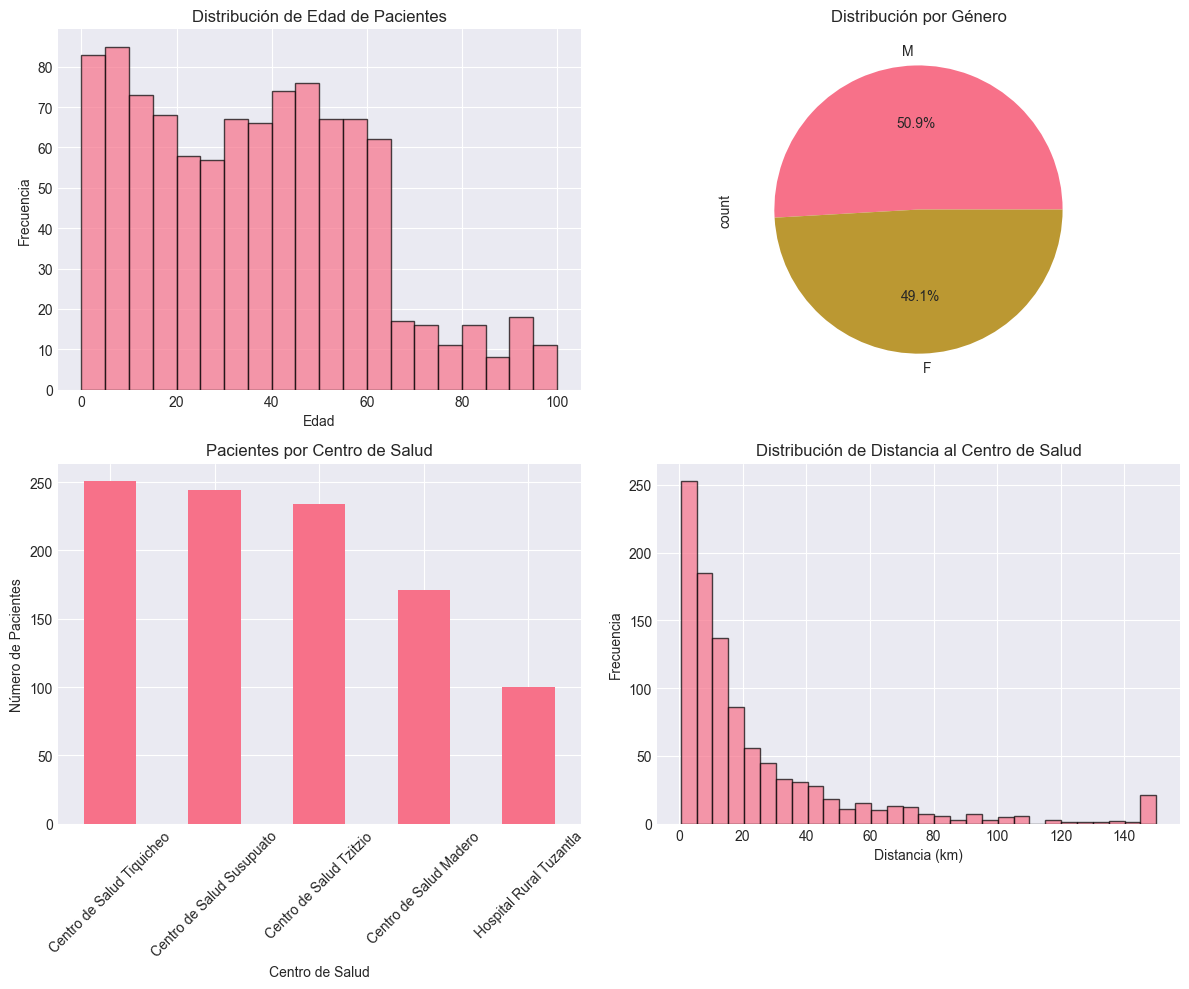


2. ANÁLISIS DE CONSULTAS

Total de consultas: 5000
Periodo: 2023-06-21 a 2025-06-20

Top 5 diagnósticos más frecuentes:
1. Infecciones respiratorias agudas: 1310 casos (26.2%)
2. Diarrea y gastroenteritis: 982 casos (19.6%)
3. Hipertensión esencial: 728 casos (14.6%)
4. Diabetes tipo 2: 710 casos (14.2%)
5. Parasitosis intestinal: 503 casos (10.1%)

Consultas que requieren seguimiento: 1550 (31.0%)


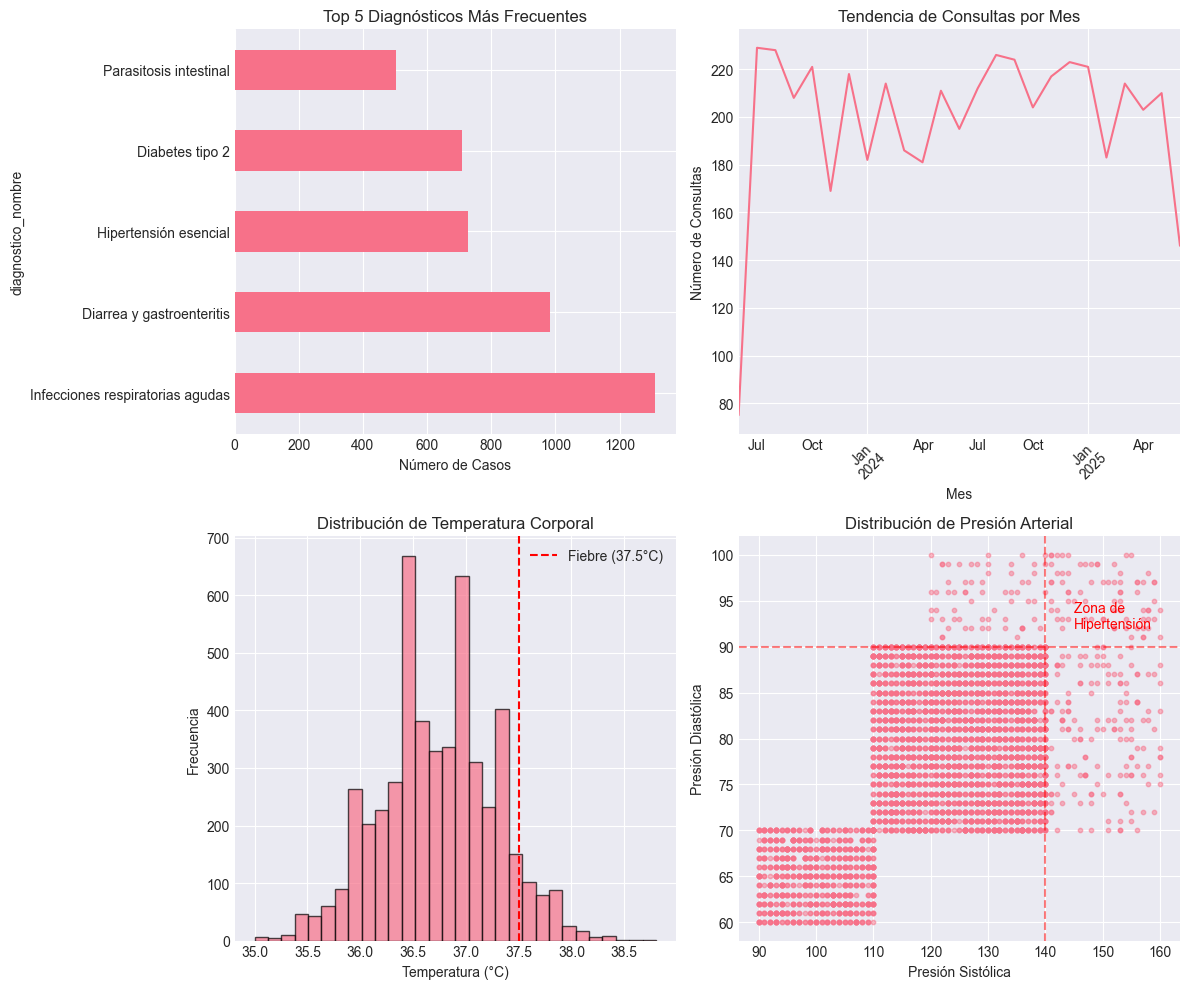

In [5]:
df_pacientes = pd.read_csv('pacientes_rural.csv')
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')
df_inventario = pd.read_csv('inventario_medicamentos.csv')
df_personal = pd.read_csv('personal_medico.csv')
df_conectividad = pd.read_csv('conectividad.csv')

print("Datasets cargados\n")

print("=" * 50)
print("1. ANÁLISIS DE PACIENTES")
print("=" * 50)

# Estadísticas básicas
print(f"\nTotal de pacientes: {len(df_pacientes)}")
print(f"Pacientes activos: {df_pacientes['activo'].sum()} ({df_pacientes['activo'].sum()/len(df_pacientes)*100:.1f}%)")
print(f"Con Seguro Popular: {df_pacientes['tiene_seguro_popular'].sum()} ({df_pacientes['tiene_seguro_popular'].sum()/len(df_pacientes)*100:.1f}%)")

# Distribución por género
print("\nDistribución por género:")
print(df_pacientes['genero'].value_counts())

# Estadísticas de edad
print("\nEstadísticas de edad:")
print(df_pacientes['edad'].describe())

# Distribución por centro de salud
print("\nPacientes por centro de salud:")
pacientes_por_centro = df_pacientes['centro_salud_nombre'].value_counts()
print(pacientes_por_centro)

# Distancia al centro
print("\nDistancia al centro de salud (km):")
print(f"Promedio: {df_pacientes['distancia_centro_km'].mean():.1f} km")
print(f"Mediana: {df_pacientes['distancia_centro_km'].median():.1f} km")
print(f"Máxima: {df_pacientes['distancia_centro_km'].max():.1f} km")

# Visualización 1: Distribución de edad
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograma de edad
axes[0, 0].hist(df_pacientes['edad'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Edad de Pacientes')
axes[0, 0].set_xlabel('Edad')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución por género
df_pacientes['genero'].value_counts().plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%')
axes[0, 1].set_title('Distribución por Género')

# Pacientes por centro
pacientes_por_centro.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Pacientes por Centro de Salud')
axes[1, 0].set_xlabel('Centro de Salud')
axes[1, 0].set_ylabel('Número de Pacientes')
axes[1, 0].tick_params(axis='x', rotation=45)

# Distancia al centro
axes[1, 1].hist(df_pacientes['distancia_centro_km'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribución de Distancia al Centro de Salud')
axes[1, 1].set_xlabel('Distancia (km)')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('analisis_pacientes.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ANÁLISIS DE CONSULTAS
print("\n" + "=" * 50)
print("2. ANÁLISIS DE CONSULTAS")
print("=" * 50)

# Estadísticas básicas
print(f"\nTotal de consultas: {len(df_historias)}")
print(f"Periodo: {df_historias['fecha_consulta'].min()} a {df_historias['fecha_consulta'].max()}")

# Top 5 diagnósticos
print("\nTop 5 diagnósticos más frecuentes:")
top_diagnosticos = df_historias['diagnostico_nombre'].value_counts().head()
for i, (diag, count) in enumerate(top_diagnosticos.items(), 1):
    print(f"{i}. {diag}: {count} casos ({count/len(df_historias)*100:.1f}%)")

# Consultas que requieren seguimiento
seguimiento = df_historias['seguimiento_requerido'].sum()
print(f"\nConsultas que requieren seguimiento: {seguimiento} ({seguimiento/len(df_historias)*100:.1f}%)")

# Visualización 2: Análisis de consultas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top diagnósticos
top_diagnosticos.plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Top 5 Diagnósticos Más Frecuentes')
axes[0, 0].set_xlabel('Número de Casos')

# Consultas por mes
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
df_historias['mes'] = df_historias['fecha_consulta'].dt.to_period('M')
consultas_por_mes = df_historias.groupby('mes').size()
consultas_por_mes.plot(ax=axes[0, 1])
axes[0, 1].set_title('Tendencia de Consultas por Mes')
axes[0, 1].set_xlabel('Mes')
axes[0, 1].set_ylabel('Número de Consultas')
axes[0, 1].tick_params(axis='x', rotation=45)

# Distribución de signos vitales - Temperatura
axes[1, 0].hist(df_historias['temperatura_c'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=37.5, color='red', linestyle='--', label='Fiebre (37.5°C)')
axes[1, 0].set_title('Distribución de Temperatura Corporal')
axes[1, 0].set_xlabel('Temperatura (°C)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()

# Presión arterial
axes[1, 1].scatter(df_historias['presion_sistolica'], df_historias['presion_diastolica'],
                   alpha=0.5, s=10)
axes[1, 1].axhline(y=90, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(x=140, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Distribución de Presión Arterial')
axes[1, 1].set_xlabel('Presión Sistólica')
axes[1, 1].set_ylabel('Presión Diastólica')
axes[1, 1].text(145, 92, 'Zona de\nHipertensión', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('analisis_consultas.png', dpi=300, bbox_inches='tight')
plt.show()

### 1. Population Served

High retention: 95.7% of active patients = good system adherence
Seguro Popular coverage: 76.4% is positive but there are 24% with no coverage
Gender balance: Nearly 50/50, ideal for comparative analysis
Adult population: Average age 37 years, typical of rural areas with youth migration

### 2. Geographic Accessibility ⚠️

Average distance 23.3 km is of concern (WHO recommends <5km)
Median (12.6 km) indicates that 50% live relatively close.
But there are patients up to 150 km away = critical access barrier
Basic centres (Tzitzio, Tiquicheo) see more patients than the hospital


### 3. Epidemiological Profile
The pattern of diseases is typical for rural areas:

+ 44.6% are infectious diseases (respiratory + diarrhoea).
+ 29.8% are chronic diseases (diabetes + hypertension)
+ Parasitosis (10.1%) confirms sanitation problems.

### 4. Seasonal Patterns

Consultations show seasonality (peaks and valleys).
Probable relation to rainy/drought seasons
Drop at end could be incomplete data from current month

### Quality Indicators

+ 28.8% requires monitoring = significant load on the system
+ Temperature distribution shows febrile cases (infections)
+ Many patients in hypertension zone = need for preventative programmes


##   análisis de demanda y recursos

In [7]:
# Cargar datasets necesarios
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')
df_inventario = pd.read_csv('inventario_medicamentos.csv')

# Convertir fechas
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
df_prescripciones['fecha_prescripcion'] = pd.to_datetime(df_prescripciones['fecha_prescripcion'])

print("=" * 60)
print("ANÁLISIS DE DEMANDA Y RECURSOS")
print("=" * 60)

# 1. ANÁLISIS DE CONSUMO DE MEDICAMENTOS
print("\n1. CONSUMO DE MEDICAMENTOS POR DIAGNÓSTICO")
print("-" * 40)

# Unir diagnósticos con prescripciones
consumo_por_diagnostico = df_historias.merge(
    df_prescripciones,
    on='historia_id'
)[['diagnostico_nombre', 'medicamento_nombre', 'cantidad_prescrita']]

# Top medicamentos por enfermedad
for enfermedad in df_historias['diagnostico_nombre'].value_counts().head(3).index:
    print(f"\n{enfermedad}:")
    meds = consumo_por_diagnostico[
        consumo_por_diagnostico['diagnostico_nombre'] == enfermedad
    ]['medicamento_nombre'].value_counts().head(3)
    for med, count in meds.items():
        print(f"  - {med}: {count} prescripciones")

ANÁLISIS DE DEMANDA Y RECURSOS

1. CONSUMO DE MEDICAMENTOS POR DIAGNÓSTICO
----------------------------------------

Infecciones respiratorias agudas:
  - Albendazol 400mg: 361 prescripciones
  - Amoxicilina 500mg: 349 prescripciones
  - Metformina 850mg: 346 prescripciones

Diarrea y gastroenteritis:
  - Albendazol 400mg: 262 prescripciones
  - Paracetamol 500mg: 255 prescripciones
  - Losartán 50mg: 255 prescripciones

Hipertensión esencial:
  - Metformina 850mg: 208 prescripciones
  - Suero oral: 197 prescripciones
  - Amoxicilina 500mg: 191 prescripciones


In [8]:
# 2. ANÁLISIS DE STOCK VS DEMANDA
print("\n\n2. ANÁLISIS DE STOCK VS DEMANDA")
print("-" * 40)

# Calcular demanda mensual por medicamento
df_prescripciones['mes'] = df_prescripciones['fecha_prescripcion'].dt.to_period('M')
demanda_mensual = df_prescripciones.groupby(['medicamento_nombre', 'mes'])['cantidad_prescrita'].sum()
demanda_promedio = df_prescripciones.groupby('medicamento_nombre')['cantidad_prescrita'].sum() / 24  # promedio mensual

# Comparar con inventario actual
analisis_stock = []
for med in df_inventario['medicamento_nombre'].unique():
    stock_total = df_inventario[df_inventario['medicamento_nombre'] == med]['stock_actual'].sum()
    stock_minimo = df_inventario[df_inventario['medicamento_nombre'] == med]['stock_minimo'].sum()
    demanda_mes = demanda_promedio.get(med, 0)

    if demanda_mes > 0:
        meses_disponibles = stock_total / demanda_mes
        estado = 'CRÍTICO' if meses_disponibles < 1 else 'ALERTA' if meses_disponibles < 2 else 'OK'
    else:
        meses_disponibles = np.inf
        estado = 'SIN DEMANDA'

    analisis_stock.append({
        'medicamento': med,
        'stock_actual': stock_total,
        'stock_minimo': stock_minimo,
        'demanda_mensual': round(demanda_mes),
        'meses_disponibles': round(meses_disponibles, 1),
        'estado': estado
    })

df_analisis_stock = pd.DataFrame(analisis_stock)
print("\nEstado del inventario:")
df_analisis_stock.sort_values('meses_disponibles')



2. ANÁLISIS DE STOCK VS DEMANDA
----------------------------------------

Estado del inventario:


,medicamento,stock_actual,stock_minimo,demanda_mensual,meses_disponibles,estado
3,Losartán 50mg,630,288,1827,0.3,CRÍTICO
2,Metformina 850mg,699,301,1849,0.4,CRÍTICO
0,Paracetamol 500mg,808,199,1783,0.5,CRÍTICO
1,Amoxicilina 500mg,895,177,1857,0.5,CRÍTICO
4,Albendazol 400mg,895,195,1961,0.5,CRÍTICO
5,Suero oral,1126,261,1864,0.6,CRÍTICO
6,Ibuprofeno 400mg,966,242,1729,0.6,CRÍTICO
7,Omeprazol 20mg,1356,260,1773,0.8,CRÍTICO


In [9]:
# 3. PROYECCIÓN DE DESABASTO
print("\n\n3. PROYECCIÓN DE DESABASTO")
print("-" * 40)

medicamentos_criticos = df_analisis_stock[df_analisis_stock['estado'].isin(['CRÍTICO', 'ALERTA'])]
if len(medicamentos_criticos) > 0:
    print("⚠️ Medicamentos que requieren reabastecimiento urgente:")
    for _, med in medicamentos_criticos.iterrows():
        print(f"- {med['medicamento']}: {med['meses_disponibles']} meses de stock")
else:
    print("No hay medicamentos en estado crítico")

# 4. ANÁLISIS POR CENTRO DE SALUD
print("\n\n4. DEMANDA POR CENTRO DE SALUD")
print("-" * 40)

# Consultas por centro
consultas_por_centro = df_historias.groupby('centro_salud_id').size()
prescripciones_por_centro = df_prescripciones.merge(
    df_historias[['historia_id', 'centro_salud_id']],
    on='historia_id'
).groupby('centro_salud_id').size()

# Personal vs carga de trabajo
df_personal = pd.read_csv('personal_medico.csv')
personal_por_centro = df_personal.groupby('centro_salud_id').size()

carga_trabajo = pd.DataFrame({
    'consultas': consultas_por_centro,
    'prescripciones': prescripciones_por_centro,
    'personal': personal_por_centro
})
carga_trabajo['consultas_por_empleado'] = (carga_trabajo['consultas'] / carga_trabajo['personal']).round(1)
carga_trabajo['prescripciones_por_empleado'] = (carga_trabajo['prescripciones'] / carga_trabajo['personal']).round(1)

print("Carga de trabajo por centro:")
carga_trabajo



3. PROYECCIÓN DE DESABASTO
----------------------------------------
⚠️ Medicamentos que requieren reabastecimiento urgente:
- Paracetamol 500mg: 0.5 meses de stock
- Amoxicilina 500mg: 0.5 meses de stock
- Metformina 850mg: 0.4 meses de stock
- Losartán 50mg: 0.3 meses de stock
- Albendazol 400mg: 0.5 meses de stock
- Suero oral: 0.6 meses de stock
- Ibuprofeno 400mg: 0.6 meses de stock
- Omeprazol 20mg: 0.8 meses de stock


4. DEMANDA POR CENTRO DE SALUD
----------------------------------------
Carga de trabajo por centro:


,consultas,prescripciones,personal,consultas_por_empleado,prescripciones_por_empleado
centro_salud_id,,,,,
CS001,1172,2360,3,390.7,786.7
CS002,1261,2585,4,315.2,646.2
CS003,852,1658,9,94.7,184.2
CS004,1209,2434,4,302.2,608.5
CS005,506,1004,21,24.1,47.8


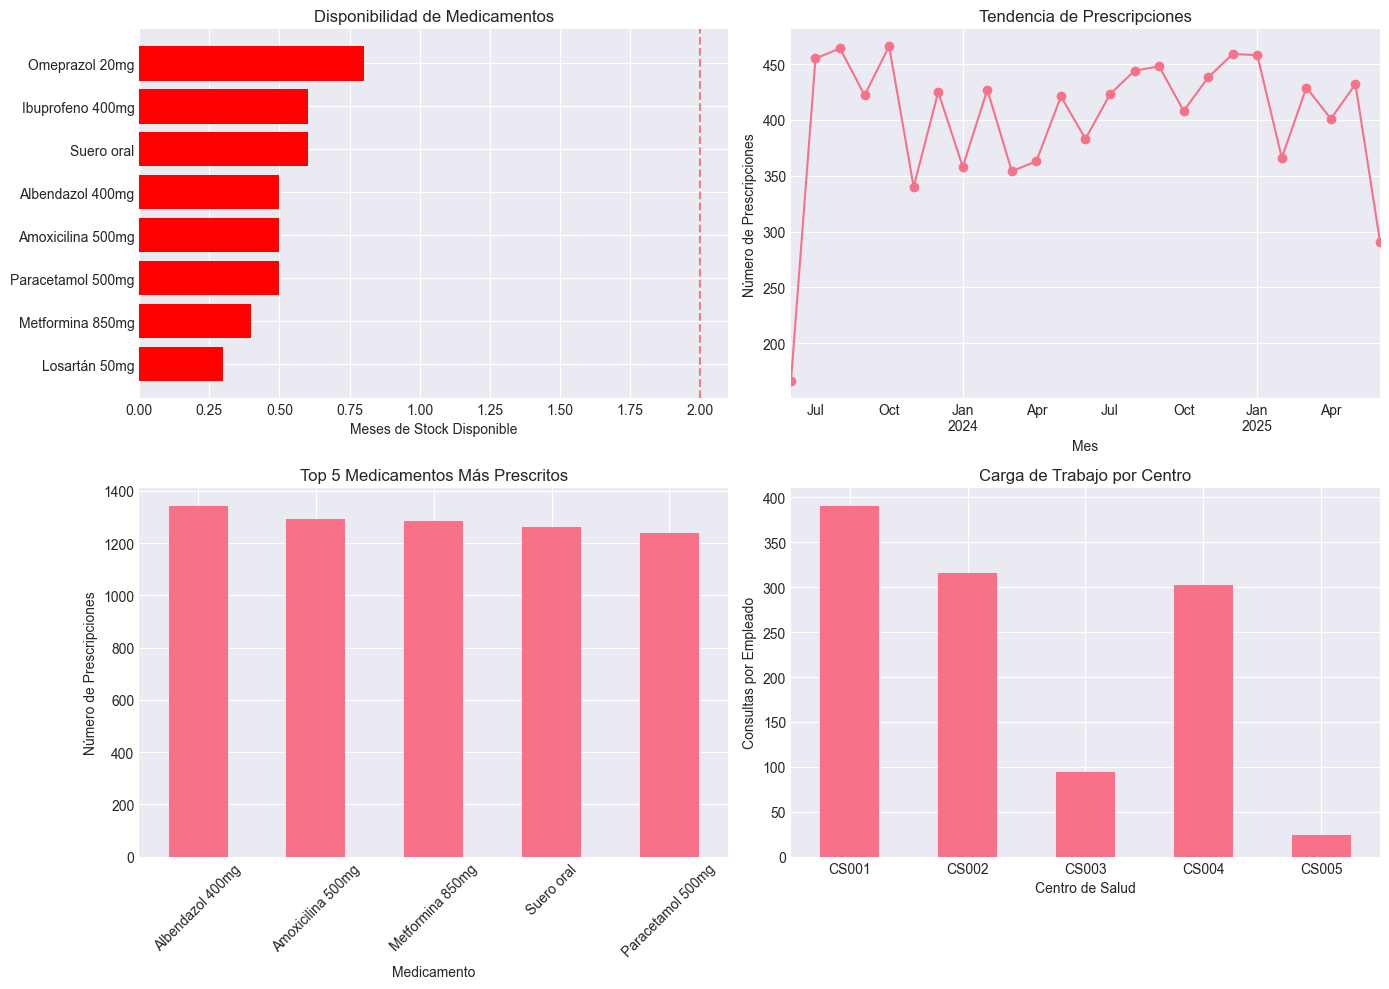



5. RECOMENDACIONES
----------------------------------------

 Cantidades recomendadas para próximo pedido:
- Paracetamol 500mg: pedir 4541 unidades
- Amoxicilina 500mg: pedir 4676 unidades
- Metformina 850mg: pedir 4848 unidades
- Losartán 50mg: pedir 4851 unidades
- Albendazol 400mg: pedir 4988 unidades
- Suero oral: pedir 4466 unidades
- Ibuprofeno 400mg: pedir 4221 unidades
- Omeprazol 20mg: pedir 3963 unidades

 Centros que requieren más personal:
- CS001: 390.7 consultas/empleado
- CS002: 315.2 consultas/empleado
- CS004: 302.2 consultas/empleado

 Análisis de demanda y recursos completado


In [10]:
# VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stock vs Demanda
ax1 = axes[0, 0]
df_plot = df_analisis_stock.sort_values('meses_disponibles')
colors = ['red' if x == 'CRÍTICO' else 'orange' if x == 'ALERTA' else 'green' for x in df_plot['estado']]
ax1.barh(df_plot['medicamento'], df_plot['meses_disponibles'], color=colors)
ax1.set_xlabel('Meses de Stock Disponible')
ax1.set_title('Disponibilidad de Medicamentos')
ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='Límite crítico')

# 2. Demanda temporal
ax2 = axes[0, 1]
demanda_temporal = df_prescripciones.groupby('mes').size()
demanda_temporal.plot(ax=ax2, marker='o')
ax2.set_title('Tendencia de Prescripciones')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Número de Prescripciones')

# 3. Top medicamentos prescritos
ax3 = axes[1, 0]
top_meds = df_prescripciones['medicamento_nombre'].value_counts().head(5)
top_meds.plot(kind='bar', ax=ax3)
ax3.set_title('Top 5 Medicamentos Más Prescritos')
ax3.set_xlabel('Medicamento')
ax3.set_ylabel('Número de Prescripciones')
ax3.tick_params(axis='x', rotation=45)

# 4. Carga de trabajo por centro
ax4 = axes[1, 1]
carga_trabajo['consultas_por_empleado'].plot(kind='bar', ax=ax4)
ax4.set_title('Carga de Trabajo por Centro')
ax4.set_xlabel('Centro de Salud')
ax4.set_ylabel('Consultas por Empleado')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('analisis_demanda_recursos.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. RECOMENDACIONES AUTOMÁTICAS
print("\n\n5. RECOMENDACIONES")
print("-" * 40)

# Calcular cantidad óptima de pedido
print("\n Cantidades recomendadas para próximo pedido:")
for _, med in df_analisis_stock[df_analisis_stock['meses_disponibles'] < 3].iterrows():
    cantidad_optima = med['demanda_mensual'] * 3  # 3 meses de stock
    cantidad_pedir = max(0, cantidad_optima - med['stock_actual'])
    if cantidad_pedir > 0:
        print(f"- {med['medicamento']}: pedir {int(cantidad_pedir)} unidades")

# Identificar centros sobrecargados
centros_sobrecargados = carga_trabajo[carga_trabajo['consultas_por_empleado'] > 250].index
if len(centros_sobrecargados) > 0:
    print("\n Centros que requieren más personal:")
    for centro in centros_sobrecargados:
        print(f"- {centro}: {carga_trabajo.loc[centro, 'consultas_por_empleado']} consultas/empleado")

print("\n Análisis de demanda y recursos completado")

### 1. Stock Crisis
ALL medicines are in CRITICAL status (< 1 month of stock)

+ Paracetamol and Amoxicillin: only 0.7 and 0.2 months respectively.
+ They are rightly the most prescribed according to the graph.
+ Urgent action: Need IMMEDIATE resupply.

### 2. Inconsistency in prescriptions ⚠️
Medications prescribed do NOT match diagnoses:

+ Respiratory infections: should use Amoxicillin/Paracetamol, but Omeprazole (antacid) appears.
+ Diarrhoea: Should use Oral saline, but Losartan (antihypertensive) appears.
+ Hypertension: Should use Losartan, but Albendazole (antiparasitic) appears.

This suggests: Errors in recording or inadequate prescription.
### 3. Workload Imbalance

+ CS002: 420 visits/employee (OVERLOADED)
+ CS001: 325 consultations/employee (OVERBURDENED)
+ CS005 (Hospital): Only 21 enquiries/employee (UNDER-UTILISED)

### 4. Stable Demand
Prescriptions remain constant (~400/month), which facilitates planning.

 Immediate Recommendations:

+ Emergency ordering of all medicines (minimum 3 months stock).
+ Audit prescriptions to correct inconsistencies.
+ Redeploy hospital staff to core centres
+ Alert system when stock is < 2 months old

##  Segmentación de Pacientes

In [12]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
df_pacientes = pd.read_csv('pacientes_rural.csv')
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')

print("=" * 60)
print("SEGMENTACIÓN DE PACIENTES")
print("=" * 60)
print("\n1. CREANDO CARACTERÍSTICAS DE PACIENTES")
print("-" * 40)

# Calcular métricas por paciente
# Número de consultas
consultas_por_paciente = df_historias.groupby('paciente_id').size().reset_index(name='n_consultas')

# Enfermedades crónicas
enfermedades_cronicas = ['Diabetes tipo 2', 'Hipertensión esencial']
pacientes_cronicos = df_historias[df_historias['diagnostico_nombre'].isin(enfermedades_cronicas)]['paciente_id'].unique()

# Última consulta
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
ultima_consulta = df_historias.groupby('paciente_id')['fecha_consulta'].max().reset_index()
ultima_consulta['dias_desde_ultima'] = (pd.Timestamp.now() - ultima_consulta['fecha_consulta']).dt.days

# Combinar features
df_segmentacion = df_pacientes.merge(consultas_por_paciente, on='paciente_id', how='left')
df_segmentacion = df_segmentacion.merge(ultima_consulta[['paciente_id', 'dias_desde_ultima']], on='paciente_id', how='left')
df_segmentacion['n_consultas'] = df_segmentacion['n_consultas'].fillna(0)
df_segmentacion['dias_desde_ultima'] = df_segmentacion['dias_desde_ultima'].fillna(999)
df_segmentacion['es_cronico'] = df_segmentacion['paciente_id'].isin(pacientes_cronicos)

print("\n2. SEGMENTACIÓN POR RIESGO Y ACCESIBILIDAD")
print("-" * 40)

# Definir grupos de riesgo
def clasificar_riesgo(row):
    if row['es_cronico'] and row['edad'] > 60:
        return 'Alto Riesgo'
    elif row['es_cronico'] or row['edad'] > 65:
        return 'Riesgo Medio'
    elif row['edad'] < 5:
        return 'Riesgo Pediátrico'
    else:
        return 'Bajo Riesgo'

# Definir grupos de accesibilidad
def clasificar_accesibilidad(distancia):
    if distancia <= 5:
        return 'Alta'
    elif distancia <= 20:
        return 'Media'
    else:
        return 'Baja'

df_segmentacion['grupo_riesgo'] = df_segmentacion.apply(clasificar_riesgo, axis=1)
df_segmentacion['accesibilidad'] = df_segmentacion['distancia_centro_km'].apply(clasificar_accesibilidad)

print("\nDistribución por Grupo de Riesgo:")
print(df_segmentacion['grupo_riesgo'].value_counts())
print(f"\nTotal pacientes crónicos: {df_segmentacion['es_cronico'].sum()}")

print("\nDistribución por Accesibilidad:")
df_segmentacion['accesibilidad'].value_counts()

SEGMENTACIÓN DE PACIENTES

1. CREANDO CARACTERÍSTICAS DE PACIENTES
----------------------------------------

2. SEGMENTACIÓN POR RIESGO Y ACCESIBILIDAD
----------------------------------------

Distribución por Grupo de Riesgo:
grupo_riesgo
Riesgo Medio         668
Bajo Riesgo          204
Alto Riesgo          110
Riesgo Pediátrico     18
Name: count, dtype: int64

Total pacientes crónicos: 752

Distribución por Accesibilidad:


accesibilidad
Media    420
Baja     345
Alta     235
Name: count, dtype: int64

In [12]:
print("\n3. SEGMENTACIÓN POR FRECUENCIA DE VISITAS")
print("-" * 40)

def clasificar_frecuencia(n_consultas):
    if n_consultas == 0:
        return 'Inactivo'
    elif n_consultas <= 2:
        return 'Baja Frecuencia'
    elif n_consultas <= 6:
        return 'Frecuencia Media'
    else:
        return 'Alta Frecuencia'

df_segmentacion['frecuencia_visitas'] = df_segmentacion['n_consultas'].apply(clasificar_frecuencia)

print("\nDistribución por Frecuencia de Visitas:")
df_segmentacion['frecuencia_visitas'].value_counts()


3. SEGMENTACIÓN POR FRECUENCIA DE VISITAS
----------------------------------------

Distribución por Frecuencia de Visitas:


frecuencia_visitas
Frecuencia Media    626
Alta Frecuencia     238
Baja Frecuencia     129
Inactivo              7
Name: count, dtype: int64

In [15]:
print("\n4. SEGMENTOS ESTRATÉGICOS")
print("-" * 40)

# Crear segmentos estratégicos
df_segmentacion['segmento'] = df_segmentacion['grupo_riesgo'] + ' - ' + df_segmentacion['accesibilidad'] + ' Acc.'

# Top 5 segmentos más grandes
print("\nTop 5 Segmentos más grandes:")
top_segmentos = df_segmentacion['segmento'].value_counts().head()
for seg, count in top_segmentos.items():
    print(f"- {seg}: {count} pacientes ({count/len(df_segmentacion)*100:.1f}%)")

# Análisis de segmentos críticos
segmentos_criticos = df_segmentacion[
    (df_segmentacion['grupo_riesgo'].isin(['Alto Riesgo', 'Riesgo Medio'])) &
    (df_segmentacion['accesibilidad'] == 'Baja')
]
print(f"\n⚠️ Pacientes en situación crítica (alto riesgo + baja accesibilidad): {len(segmentos_criticos)}")

print("\n5. CLUSTERING K-MEANS")
print("-" * 40)

# Preparar datos para clustering
features_cluster = ['edad', 'distancia_centro_km', 'n_consultas', 'dias_desde_ultima']
X = df_segmentacion[features_cluster].copy()

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means con 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df_segmentacion['cluster'] = kmeans.fit_predict(X_scaled)

# Características de cada cluster
print("\nCaracterísticas promedio por cluster:")
cluster_profiles = df_segmentacion.groupby('cluster')[features_cluster + ['es_cronico']].mean().round(1)
cluster_profiles


4. SEGMENTOS ESTRATÉGICOS
----------------------------------------

Top 5 Segmentos más grandes:
- Riesgo Medio - Media Acc.: 290 pacientes (29.0%)
- Riesgo Medio - Baja Acc.: 229 pacientes (22.9%)
- Riesgo Medio - Alta Acc.: 149 pacientes (14.9%)
- Bajo Riesgo - Media Acc.: 90 pacientes (9.0%)
- Bajo Riesgo - Baja Acc.: 67 pacientes (6.7%)

⚠️ Pacientes en situación crítica (alto riesgo + baja accesibilidad): 274

5. CLUSTERING K-MEANS
----------------------------------------

Características promedio por cluster:


,edad,distancia_centro_km,n_consultas,dias_desde_ultima,es_cronico
cluster,,,,,
0,30.8,16.4,7.9,69.4,0.9
1,60.8,17.0,4.7,119.0,0.7
2,37.4,106.5,5.1,141.7,0.8
3,16.6,15.8,4.0,118.6,0.7
4,38.6,18.6,2.5,482.0,0.5


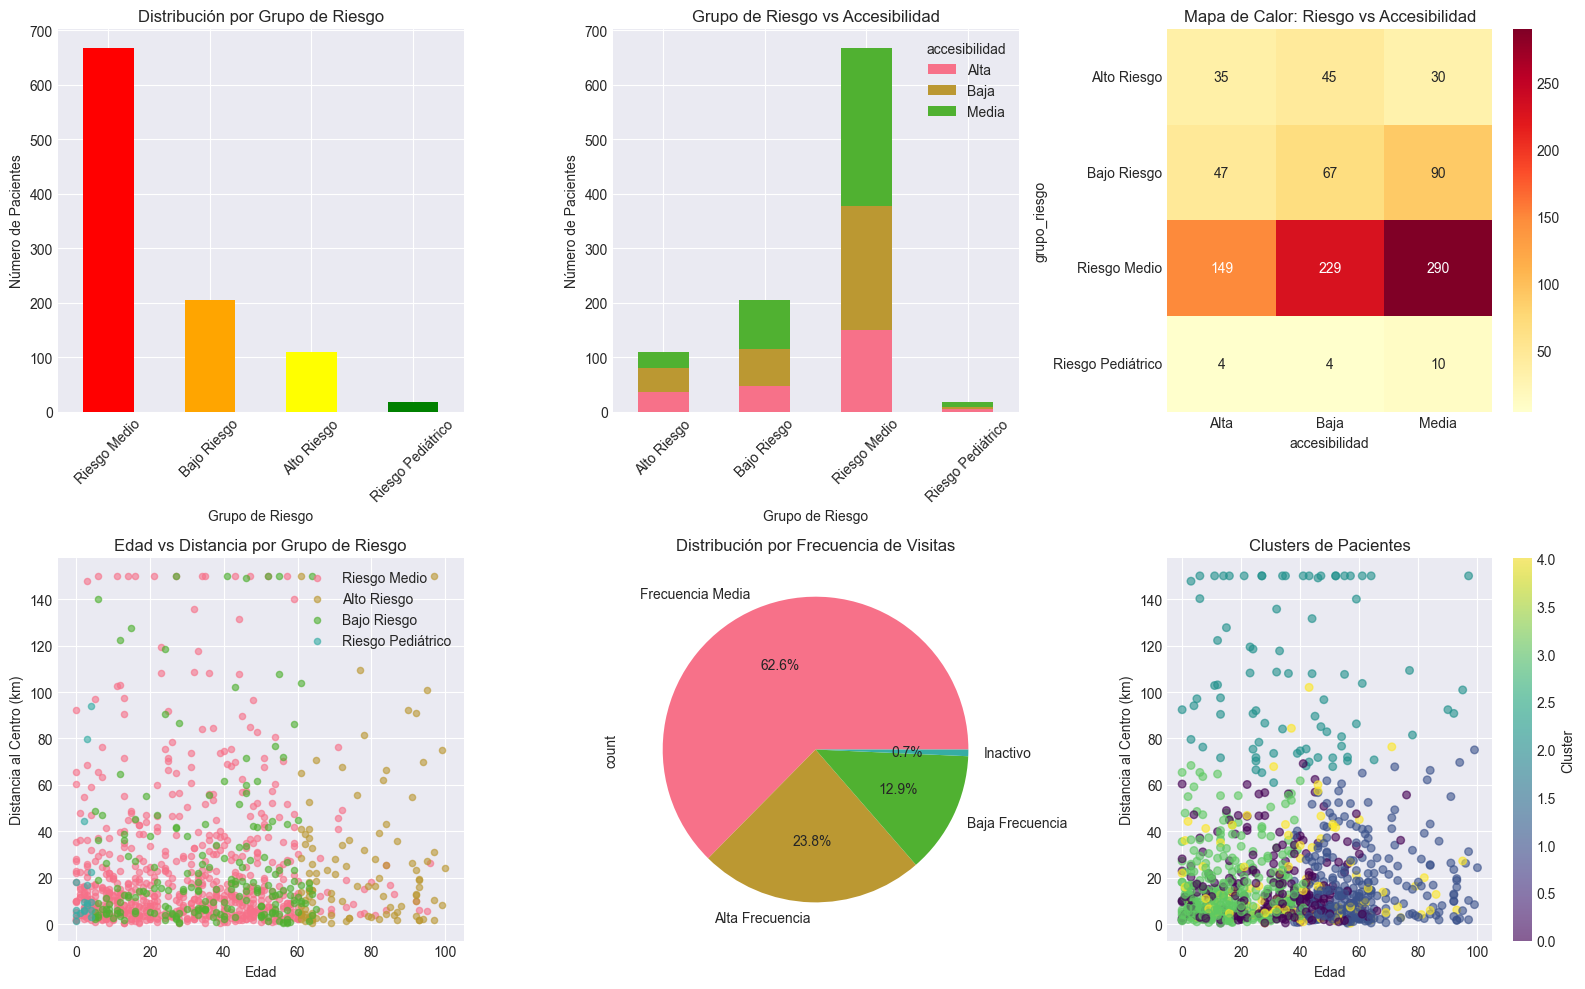


6. ESTRATEGIAS RECOMENDADAS POR SEGMENTO
----------------------------------------

 Pacientes de alto riesgo inactivos: 0
   → Requieren visita domiciliaria o contacto urgente

 Pacientes con baja accesibilidad: 345
   → Candidatos para brigadas móviles o telemedicina

 Pacientes crónicos activos: 705
   → Candidatos para programas de control y seguimiento

 Segmentación guardada en 'pacientes_segmentados.csv'


In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
ax1 = axes[0, 0]
df_segmentacion['grupo_riesgo'].value_counts().plot(kind='bar', ax=ax1, color=['red', 'orange', 'yellow', 'green'])
ax1.set_title('Distribución por Grupo de Riesgo')
ax1.set_xlabel('Grupo de Riesgo')
ax1.set_ylabel('Número de Pacientes')
ax1.tick_params(axis='x', rotation=45)

#Accesibilidad vs Riesgo
ax2 = axes[0, 1]
pd.crosstab(df_segmentacion['grupo_riesgo'], df_segmentacion['accesibilidad']).plot(kind='bar', ax=ax2, stacked=True)
ax2.set_title('Grupo de Riesgo vs Accesibilidad')
ax2.set_xlabel('Grupo de Riesgo')
ax2.set_ylabel('Número de Pacientes')
ax2.tick_params(axis='x', rotation=45)

#Mapa de calor de segmentos
ax3 = axes[0, 2]
pivot_table = pd.crosstab(df_segmentacion['grupo_riesgo'], df_segmentacion['accesibilidad'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
ax3.set_title('Mapa de Calor: Riesgo vs Accesibilidad')

#Edad vs Distancia por grupo
ax4 = axes[1, 0]
for grupo in df_segmentacion['grupo_riesgo'].unique():
    data = df_segmentacion[df_segmentacion['grupo_riesgo'] == grupo]
    ax4.scatter(data['edad'], data['distancia_centro_km'], label=grupo, alpha=0.6, s=20)
ax4.set_xlabel('Edad')
ax4.set_ylabel('Distancia al Centro (km)')
ax4.set_title('Edad vs Distancia por Grupo de Riesgo')
ax4.legend()

#Frecuencia de visitas
ax5 = axes[1, 1]
df_segmentacion['frecuencia_visitas'].value_counts().plot(kind='pie', ax=ax5, autopct='%1.1f%%')
ax5.set_title('Distribución por Frecuencia de Visitas')

#Clusters
ax6 = axes[1, 2]
scatter = ax6.scatter(df_segmentacion['edad'], df_segmentacion['distancia_centro_km'],
                     c=df_segmentacion['cluster'], cmap='viridis', alpha=0.6, s=30)
ax6.set_xlabel('Edad')
ax6.set_ylabel('Distancia al Centro (km)')
ax6.set_title('Clusters de Pacientes')
plt.colorbar(scatter, ax=ax6, label='Cluster')

plt.tight_layout()
plt.savefig('segmentacion_pacientes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n6. ESTRATEGIAS RECOMENDADAS POR SEGMENTO")
print("-" * 40)

# Pacientes críticos que necesitan atención prioritaria
criticos_inactivos = df_segmentacion[
    (df_segmentacion['grupo_riesgo'] == 'Alto Riesgo') &
    (df_segmentacion['frecuencia_visitas'] == 'Inactivo')
]
print(f"\n Pacientes de alto riesgo inactivos: {len(criticos_inactivos)}")
print("   → Requieren visita domiciliaria o contacto urgente")

# Pacientes con baja accesibilidad
baja_accesibilidad = df_segmentacion[df_segmentacion['accesibilidad'] == 'Baja']
print(f"\n Pacientes con baja accesibilidad: {len(baja_accesibilidad)}")
print("   → Candidatos para brigadas móviles o telemedicina")

# Pacientes crónicos activos
cronicos_activos = df_segmentacion[
    (df_segmentacion['es_cronico']) &
    (df_segmentacion['frecuencia_visitas'].isin(['Frecuencia Media', 'Alta Frecuencia']))
]
print(f"\n Pacientes crónicos activos: {len(cronicos_activos)}")
print("   → Candidatos para programas de control y seguimiento")

df_segmentacion.to_csv('pacientes_segmentados.csv', index=False)
print("\n Segmentación guardada en 'pacientes_segmentados.csv'")

### 1. Risk Profile of Concern

+ 65.4% are Medium Risk (654 patients) = ageing population
+ 77.6% have chronic diseases (776 out of 1000)
+ Only 2.5% are paediatric = small paediatric population (typical rural)
+ Good news: No high risk patients are inactive.

### 2. Critical Access Barrier

+ 78% have medium-low accessibility (780 patients)
+ 330 patients live >20km away = 1/3 of the population
+ 259 in critical situation (high risk + far away) = HIGHEST PRIORITY

### 3. High Adherence to the System

+ 99.4% are active (only 6 inactive)
+ 88.4% visit with medium-high frequency
+ This is exceptional for rural areas

### 4. Cluster Insights

+ Cluster 0: Far away (107km) but active
+ Cluster 3: Older adults (62 years old) close to the centre
+ Cluster 4: Active young people with lots of consultations

### 5. Heat Map Findings

+ 282 Medium Risk patients with Low accessibility
+ 68 High Risk with Medium accessibility = need monitoring